# Import the different Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings

from keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate
from keras.models import Model

warnings.filterwarnings('ignore')
%matplotlib inline

Using TensorFlow backend.


# Introduction to Recommender Systems

A recommender system, in simple terms, seeks to model a user’s behavior regarding targeted items and/or products.     A recommender system leverages user data to better understand how they interact with items. 
(Items here are books)

## Book Recommandation system 

In this Notebook, we’ll be using a neural network approach to building a collaborative filtering recommender system.
We’ll use something called an embedding to build a profile/understanding of the interactions between users and books.(it’s more of a hybrid approach)
We will create this recommandation system by leveraging existing data of books, users, and ratings given by users. 
After that a special kind of neural network layer called an embedding will be trained on this interaction by learning the similarity between books in something called an embedding space.
The knowledge, gained using the similarity will be combined with the user ratings of each book to train a neural network

### This is a classic regression approach, where the input is the learned embedding of book-user interaction, and the target/labels are book ratings given by the users.


# Import the dataset of book rating 

In [2]:
dataset = pd.read_csv('ratings.csv')

In [3]:
dataset.head()

,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


the ratings dataset contains just three columns: book_id, user_id, and the corresponding rating given by the user.

In [4]:
dataset.shape

(981756, 3)

the shape of the dataset (number of row and column)

# Split the data into train and test
To effectively evaluate the model performance (because we’re treating this as a regression problem) test size of 0.2 (20%)

In [5]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(dataset, test_size=0.20, random_state=42)

In [6]:
print(f"Shape of train data: {train.shape}")
print(f"Shape of test data: {test.shape}")

Shape of train data: (785404, 3)
Shape of test data: (196352, 3)


# Building the recommendation engine using TensorFlow / Keras
The neural network we will create will have two input embedding layers. The first embedding layer accepts the books, and the second the users. These two embeddings are trained separately and then combined together before being passed to a dense layer.

### we will start by Geting the number of unique entities in books and users column

In [7]:
n_users = len(dataset.user_id.unique())
n_users

53424

In [8]:
n_books = len(dataset.book_id.unique())
n_books

10000

In [9]:
import tensorflow.keras as tf

#Book input network
## First we create an input layer to accept a 1 D array of book IDs
input_books = tf.layers.Input(shape=[1])
## Second we create an embedding layer (hidden layer of a network) with the shape of (number of unique books + 1,5)
## The second dimension (5), is an arbitrary dimension we chose. (how large we want the embedding layer to be)
## we append the input layer to the end of the book embedding layer. 
## We want by that passing the output of the input layer to the embedding layer.
embed_books = tf.layers.Embedding(n_books + 1,15)(input_books)
## Flattening a tensor means to remove all of the dimensions except for one.
books_out = tf.layers.Flatten()(embed_books)

#user input network
input_users = tf.layers.Input(shape=[1])
embed_users = tf.layers.Embedding(n_users + 1,15)(input_users)
users_out = tf.layers.Flatten()(embed_users)

##concatenate line, we simply concatenate or join both the books and the user embedding layer together,
conc_layer = tf.layers.Concatenate()([books_out, users_out])
##add a single dense layer with 128 nodes on top of it. 
x = tf.layers.Dense(128, activation='relu')(conc_layer)
##For the final layer of the network, we use a single node, 
##because we’re predicting the ratings given to each book, and that requires just a single node.
x_out = x = tf.layers.Dense(1, activation='relu')(x)
model = tf.Model([input_books, input_users], x_out)

In [10]:
opt = tf.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mean_squared_error')
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 15)        150015      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 15)        801375      input_2[0][0]                    
_______________________________________________________________________________________

In [11]:
history = model.fit([train.book_id, train.user_id], train.rating, 
                 batch_size=64, 
                 epochs=5, 
                 verbose=1,
                 validation_data=([test.book_id, test.user_id], test.rating))


Epoch 1/5
 4089/12272 [========>.....................] - ETA: 5:02 - loss: 1.0929

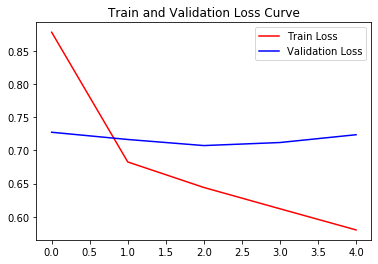

In [12]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(train_loss, color='r', label='Train Loss')
plt.plot(val_loss, color='b', label='Validation Loss')
plt.title("Train and Validation Loss Curve")
plt.legend()
plt.show()

# Making Recommendations for Users
In order to make recommendations, we need to pass in the list of books and a particular user to the model. That is, the model will make a prediction of a rating it thinks the user will give to books based on its understanding of the user.
These ratings are then sorted in ascending order of magnitude. Therefore, if we want to, say, recommend 10 books to a user, we’ll pass in a list of books to the model to predict ratings it feels the user will give to those books. Then we pick the top 10 of these ratings and recommend those books to the user.

In [13]:
book_data = np.array(list(set(dataset.book_id)))
book_data

array([    1,     2,     3, ...,  9998,  9999, 10000])

In [14]:
user = np.array([100 for i in range(len(list(set(dataset.book_id))))])
user

array([100, 100, 100, ..., 100, 100, 100])

In [15]:
pred = model.predict([book_data, user])
pred

array([[4.4266624],
       [4.174655 ],
       [3.1848145],
       ...,
       [4.370235 ],
       [3.8025646],
       [3.9416952]], dtype=float32)

In [16]:
pred = pred.reshape(-1) #reshape to single dimension
pred_ids = (-pred).argsort()[0:5]
pred_ids

array([9075, 6589, 7946, 3752, 8853])

In [17]:
books  = pd.read_csv('/Users/mac/Downloads/books/books.csv')
books.head()

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [18]:
books.iloc[pred_ids]

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
9075,9076,2350129,2350129,2356840,5,402366174,9.780402e+12,The Church of Jesus Christ of Latter-day Saints,2004.0,Preach My Gospel (A Guide to Missionary Service),...,9891,10194,206,105,83,463,1365,8178,https://images.gr-assets.com/books/1399612262m...,https://images.gr-assets.com/books/1399612262s...
6589,6590,59715,59715,1010526,21,751507954,9.780752e+12,Bill Watterson,1990.0,The Authoritative Calvin and Hobbes,...,16087,18198,425,20,61,701,3295,14121,https://images.gr-assets.com/books/1391114055m...,https://images.gr-assets.com/books/1391114055s...
7946,7947,5031805,5031805,40769318,96,1433502410,9.781434e+12,"Anonymous, Lane T. Dennis, Wayne A. Grudem",2002.0,NaN,...,8953,10784,262,98,90,367,1152,9077,https://images.gr-assets.com/books/1410151002m...,https://images.gr-assets.com/books/1410151002s...
3752,3753,10,10,21457570,6,439827604,9.780440e+12,J.K. Rowling,2005.0,"Harry Potter Collection (Harry Potter, #1-6)",...,24618,26274,882,203,186,946,3891,21048,https://images.gr-assets.com/books/1328867351m...,https://images.gr-assets.com/books/1328867351s...
8853,8854,95602,95602,920037,6,842339523,9.780842e+12,Francine Rivers,1993.0,Mark of the Lion Trilogy,...,9081,9547,731,27,61,323,1363,7773,https://images.gr-assets.com/books/1349032180m...,https://images.gr-assets.com/books/1349032180s...
